In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')

# Computing daily energy needs

First factor: your reference energy need.

See [https://en.wikipedia.org/wiki/Harris–Benedict_equation].

In [2]:
def energy_need_female(physical_activity, weight_kg, height_cm, age):
    return physical_activity * (9.99 * weight_kg + 6.25 * height_cm - 4.92 * age - 161)

In [3]:
def energy_need_male(physical_activity, weight_kg, height_cm, age):
    return physical_activity * (9.99 * weight_kg + 6.25 * height_cm - 4.92 * age + 5)

In [10]:
def print_energy(physical_activity, weight_kg, height_cm, age):
    print("male: {:.0f} Cal, female: {:.0f} Cal".format(energy_need_male(physical_activity, weight_kg, height_cm, age),
                                                energy_need_female(physical_activity, weight_kg, height_cm, age)))

In [11]:
from ipywidgets import interact

In [12]:
interact(print_energy,
         physical_activity=(1.4, 1.8, 0.01),
         weight_kg=(20, 150, 0.5),
         height_cm=(150, 220, 0.5),
         age=(18, 99))

interactive(children=(FloatSlider(value=1.5999999999999999, description='physical_activity', max=1.8, min=1.4, step=0.01), FloatSlider(value=85.0, description='weight_kg', max=150.0, min=20.0, step=0.5), FloatSlider(value=185.0, description='height_cm', max=220.0, min=150.0, step=0.5), IntSlider(value=58, description='age', max=99, min=18), Output()), _dom_classes=('widget-interact',))

<function __main__.print_energy>

Let's make some better graphics.

In [13]:
import numpy as np

In [16]:
weight_kg = np.linspace(40, 100, num=50).reshape(-1, 1)
height_cm = np.linspace(150, 200, num=60).reshape(1, -1)

In [18]:
females_not_active = energy_need_female(1.4, weight_kg, height_cm, 30)
females_active = energy_need_female(1.7, weight_kg, height_cm, 30)

Text(0,0.5,'weight (kg)')

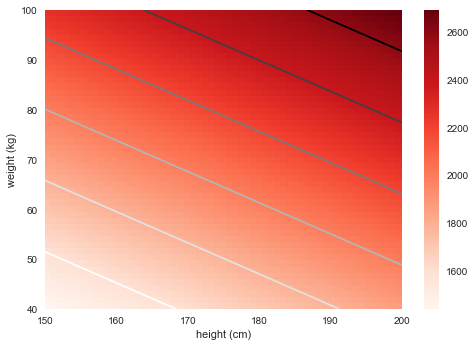

In [38]:
X, Y = np.meshgrid(height_cm.flat, weight_kg.flat)
plt.pcolormesh(X, Y, females_not_active, cmap='Reds')
plt.colorbar()
plt.contour(X, Y, females_not_active)
plt.xlabel('height (cm)')
plt.ylabel('weight (kg)')

In [49]:
def plot_meshgrid(ax, X, Y, mapping, title, xlabel, ylabel):
    obj = ax.pcolormesh(X, Y, mapping, cmap='Reds')
    plt.colorbar(obj, ax=ax)
    ax.contour(X, Y, mapping)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

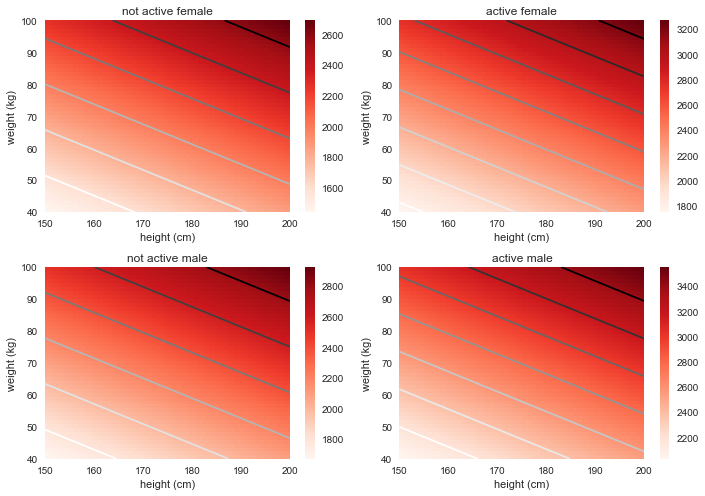

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
plot_meshgrid(axes[0, 0], X, Y, energy_need_female(1.4, weight_kg, height_cm, 30), 'not active female', 'height (cm)', 'weight (kg)')
plot_meshgrid(axes[0, 1], X, Y, energy_need_female(1.7, weight_kg, height_cm, 30), 'active female', 'height (cm)', 'weight (kg)')
plot_meshgrid(axes[1, 0], X, Y, energy_need_male(1.4, weight_kg, height_cm, 30), 'not active male', 'height (cm)', 'weight (kg)')
plot_meshgrid(axes[1, 1], X, Y, energy_need_male(1.7, weight_kg, height_cm, 30), 'active male', 'height (cm)', 'weight (kg)')
plt.tight_layout()

# Computing weight change over time

Second factor: how long does it take to lose weight?

Wishnofsky: to lose one kilogram of weight, you need to get rid of 7700 calories.

The mecanism is easy:

- compute a daily balance 
- convert the $\Delta$ to grams
- take into account the new energy need (you have lost weight and now need less energy)

In [56]:
class Person:
    def __init__(self, sex, physical_activity, weight_kg, height_cm, age):
        self.sex = sex
        self.physical_activity = physical_activity
        self.start_weight = weight_kg
        self.height_cm = height_cm
        self.start_age = age
        
        self.current_weight = weight_kg
        self.current_age = age
        
    def energy_need(self):
        if self.sex == 'male':
            return energy_need_male(self.physical_activity, 
                           self.current_weight,
                           self.height_cm,
                           self.current_age)
        elif self.sex == 'female':
            return energy_need_female(self.physical_activity, 
                           self.current_weight,
                           self.height_cm,
                           self.current_age) 
    
    def increment_day(self, daily_energy_intake):
        energy_balance = daily_energy_intake - self.energy_need()
        self.current_weight += energy_balance / 7700

In [57]:
p = Person('female', 1.5, 90, 165, 35)

In [58]:
90 / 1.65 /1.65

33.057851239669425

In [59]:
p.energy_need()

2395.725

In [60]:
delta = p.energy_need() - 500
delta

1895.725

In [61]:
500 / 2400

0.20833333333333334

One can simulate what happens to the weight by eating 500 Cal less than the required initial energy content.

In [62]:
p = Person('female', 1.5, 90, 165, 35)

t_days = range(365)
weights = []

for i in t_days:
    weights.append(p.current_weight)
    p.increment_day(delta)

Text(0,0.5,'poids (kg)')

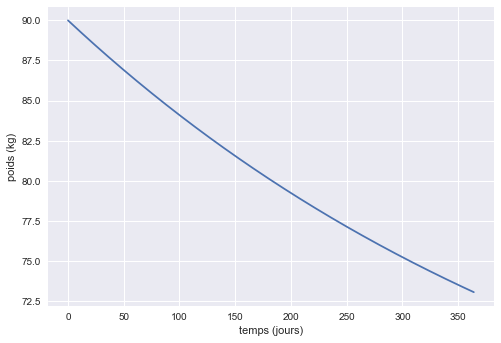

In [63]:
plt.plot(t_days, weights)
plt.xlabel('temps (jours)')
plt.ylabel('poids (kg)')

What about 5 years?

In [64]:
p = Person('female', 1.5, 90, 165, 35)

t_days = range(365 * 5)
weights = []

for i in t_days:
    weights.append(p.current_weight)
    p.increment_day(delta)

In [65]:
weights[-1]

57.58873010537209

Text(0,0.5,'weight (kg)')

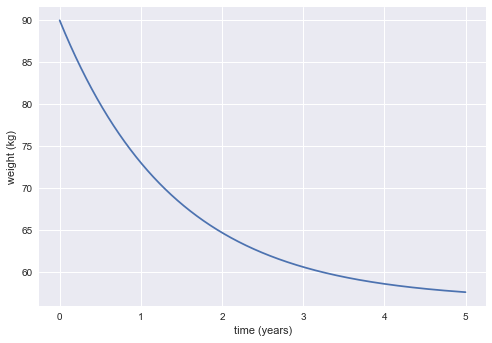

In [66]:
plt.plot(np.array(t_days) / 365., weights)
plt.xlabel(u'time (years)')
plt.ylabel('weight (kg)')

We can do an interactive simulation for any person based on the same type of computation:

In [67]:
def plot_simulation(sex, physical_activity, weight_kg, height_cm, age, caloric_delta_from_starting_weight):
    p = Person(sex, physical_activity, weight_kg, height_cm, age)
    
    initial_energy_need = p.energy_need()
    daily_consumption = initial_energy_need - caloric_delta_from_starting_weight

    t_days = range(365 * 10)
    weights = []
    for i in t_days:
        weights.append(p.current_weight)
        p.increment_day(daily_consumption)
        
        
    plt.plot(np.array(t_days) / 365., weights)
    plt.xlabel(u'time (years)')
    plt.ylabel('weight (kg)')
    plt.show()

In [68]:
interact(plot_simulation,
         sex=['male', 'female'],
         physical_activity=(1.4, 1.8, 0.01),
         weight_kg=(20, 150, 0.5),
         height_cm=(150, 220, 0.5),
         age=(18, 99),
         caloric_delta_from_starting_weight=(-2000, 2000, 10))

interactive(children=(Dropdown(description='sex', options=('male', 'female'), value='male'), FloatSlider(value=1.5999999999999999, description='physical_activity', max=1.8, min=1.4, step=0.01), FloatSlider(value=85.0, description='weight_kg', max=150.0, min=20.0, step=0.5), FloatSlider(value=185.0, description='height_cm', max=220.0, min=150.0, step=0.5), IntSlider(value=58, description='age', max=99, min=18), IntSlider(value=0, description='caloric_delta_from_starting_weight', max=2000, min=-2000, step=10), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_simulation>

# Taking into account the age in the weight change over time

In [69]:
class AgingPerson(Person):
    def increment_day(self, daily_energy_intake):
        energy_balance = daily_energy_intake - self.energy_need()
        self.current_weight += energy_balance / 7700
        self.current_age += 1 / 365.

In [70]:
def plot_simulation_with_aging(sex, physical_activity, weight_kg, height_cm, age, caloric_delta_from_starting_weight):
    p = AgingPerson(sex, physical_activity, weight_kg, height_cm, age)
    
    initial_energy_need = p.energy_need()
    daily_consumption = initial_energy_need - caloric_delta_from_starting_weight

    t_days = range(365 * 10)
    weights = []
    for i in t_days:
        weights.append(p.current_weight)
        p.increment_day(daily_consumption)
        
        
    plt.plot(np.array(t_days) / 365., weights)
    plt.xlabel(u'time (years)')
    plt.ylabel('weight (kg)')
    plt.show()

In [71]:
interact(plot_simulation_with_aging,
         sex=['male', 'female'],
         physical_activity=(1.4, 1.8, 0.01),
         weight_kg=(20, 150, 0.5),
         height_cm=(150, 220, 0.5),
         age=(18, 99),
         caloric_delta_from_starting_weight=(-2000, 2000, 10))

interactive(children=(Dropdown(description='sex', options=('male', 'female'), value='male'), FloatSlider(value=1.5999999999999999, description='physical_activity', max=1.8, min=1.4, step=0.01), FloatSlider(value=85.0, description='weight_kg', max=150.0, min=20.0, step=0.5), FloatSlider(value=185.0, description='height_cm', max=220.0, min=150.0, step=0.5), IntSlider(value=58, description='age', max=99, min=18), IntSlider(value=0, description='caloric_delta_from_starting_weight', max=2000, min=-2000, step=10), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_simulation_with_aging>

What we see now is the effect of aging: the older you are, the less energy you need. So eating the same amount of food will, at some point, will make you gain weight.

# The problem with weighing yourself

It is known from the litterature that your weight fluctuates daily with important variations. Suppose you weight 70 kilos, your weight might be between 68 and 72 kilos. We can simulate the real weight measured over 15 days with very little code:

In [72]:
np.random.seed(42)
weights = np.random.random(size=15) * 4 - 2 + 70

Let's plot this:

Text(0,0.5,'weight')

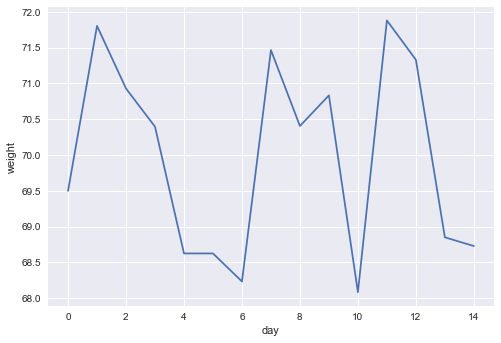

In [73]:
plt.plot(weights)
plt.xlabel('day')
plt.ylabel('weight')

Now suppose you measure your weight every week once. This corresponds to measures on day 0 and 7. Your measured average will be:

In [74]:
(weights[0] + weights[7])/2.

70.4814325292446

If you do that, you might think you gained weight since you last weighed yourself. What if you measured yourself on the fourth day of every week?

In [75]:
(weights[3] + weights[10])/2.

69.23848595698568

In that case you migth think you have lost some weight, even if you haven't. 

The point is: due to the randome fluctuations of your weight, you should measure it more often than not! Practically, this means that if you average your weight over every day in the last two weeks, you fill get an accurate measurement of your weight:

In [76]:
weights.mean()

69.97825824657875

See? Very close to 70 kilograms!

To demonstrate the effect of this "how often do your weigh yourself", we can write a little program that takes as input the period of measurement (14 days in our previous example) and the interval between each time you weigh yourself during that period. Based on this data, we can compute the mean error based on the fact that the true weight is known as a simulation input:

In [77]:
def simulate_weight_measurement(true_weight, observation_period, measure_every_x_days):
    weights = true_weight + np.random.random(size=observation_period * 1000) * 4 - 2
    measured_error = (true_weight - np.mean(weights[::measure_every_x_days])) / true_weight
    return np.abs(measured_error.mean())

In [82]:
simulate_weight_measurement(70, 7, 7) * 100

0.03607601444431095